In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries loaded!")

✓ Libraries loaded!


In [2]:
df = pd.read_csv("../emails_data.csv")

print(f"Loaded {len(df)} emails")
print(f"Columns: {list(df.columns)}")
df.head()

Loaded 658 emails
Columns: ['id', 'sender', 'subject', 'date', 'body_preview', 'snippet']


,id,sender,subject,date,body_preview,snippet
0,19b103705ee208c5,Indeed <alert@indeed.com>,"UC San Diego Health is hiring for Valet Attendant. 8 more valet jobs in san diego, ca.",2025-12-11 17:39:57-08:00,"Indeed Job Alert\r\n9 new valet jobs in san diego, ca\r\n\r\nJobs 1-7 of 9 new jobs\r\nSee match...","Apply now at Towne Park, LAZ Parking, and Sycuan Casino Resort ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌..."
1,19b1003c8e521145,Handshake <handshake@notifications.joinhandshake.com>,UC San Diego just posted a role 🌟,2025-12-11 16:44:00-08:00,"Apply early to stand out\r\n\r\n\r\nYou might be a match for this new job from UC San Diego, bas...","Handshake Apply early to stand out You might be a match for this new job from UC San Diego, base..."
2,19b0fcd0d8d7bc22,"""ANTH 21 - Race and Racisms - Kang [FA25]"" <notifications@instructure.com>",Assignment Graded: Dec. 4 – Reading: “Genomic Supremacy: The Harm of Conflating Genetic Ancestry...,2025-12-11 15:44:13-08:00,Your assignment Dec. 4 – Reading: “Genomic Supremacy: The Harm of Conflating Genetic Ancestry an...,Your assignment Dec. 4 – Reading: “Genomic Supremacy: The Harm of Conflating Genetic Ancestry an...
3,19b0fcc4a9cff26b,"""ANTH 21 - Race and Racisms - Kang [FA25]"" <notifications@instructure.com>",Assignment Graded: Dec. 2 – Reading: “The Illusion of Inclusion - The ‘All of Us’ Research Progr...,2025-12-11 15:43:23-08:00,Your assignment Dec. 2 – Reading: “The Illusion of Inclusion - The ‘All of Us’ Research Program ...,Your assignment Dec. 2 – Reading: “The Illusion of Inclusion - The 'All of Us' Research Program ...
4,19b0fcbc97da466a,"""ANTH 21 - Race and Racisms - Kang [FA25]"" <notifications@instructure.com>",Assignment Graded: Nov. 25 – Becoming White: Jews in America and the Resurgence of Fashionable A...,2025-12-11 15:42:49-08:00,Your assignment Nov. 25 – Becoming White: Jews in America and the Resurgence of Fashionable Anti...,Your assignment Nov. 25 – Becoming White: Jews in America and the Resurgence of Fashionable Anti...


In [3]:
print(f"Shape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"Unique Senders: {df.get('sender').nunique()}")

Shape: (658, 6)

Data Types:
id              object
sender          object
subject         object
date            object
body_preview    object
snippet         object
dtype: object

Missing values:
id              0
sender          0
subject         0
date            0
body_preview    0
snippet         0
dtype: int64
Unique Senders: 141


### Convert Data Types

In [4]:

print("Converting dates to Pacific Time...")

# Convert to UTC first, then to Pacific Time
df['datetime'] = pd.to_datetime(df['date'], utc=True, errors='coerce')
df['datetime'] = df['datetime'].dt.tz_convert('America/Los_Angeles')

# Extract time features in Pacific Time
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.day_name()
df['date_only'] = df['datetime'].dt.date
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['day_of_month'] = df['datetime'].dt.day
df['is_weekend'] = df['datetime'].dt.weekday >= 5

# Time of day categories
df['time_of_day'] = pd.cut(
    df['hour'], 
    bins=[0, 6, 12, 18, 24], 
    labels=['Night (12am-6am)', 'Morning (6am-12pm)', 
            'Afternoon (12pm-6pm)', 'Evening (6pm-12am)'],
    include_lowest=True
)

print(f"✓ Conversion complete!")
print(f"  Timezone: {df['datetime'].dt.tz}")
print(f"  Date range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"  Failed conversions: {df['datetime'].isna().sum()}")

print("\n📊 Sample data:")
print(df[['date', 'datetime', 'hour', 'day_of_week', 'time_of_day']].head(3))

print("\n✓ All times now in Pacific Time!")

Converting dates to Pacific Time...
✓ Conversion complete!
  Timezone: America/Los_Angeles
  Date range: 2025-11-11 16:59:58-08:00 to 2025-12-11 17:39:57-08:00
  Failed conversions: 0

📊 Sample data:
                        date                  datetime  hour day_of_week  \
0  2025-12-11 17:39:57-08:00 2025-12-11 17:39:57-08:00    17    Thursday   
1  2025-12-11 16:44:00-08:00 2025-12-11 16:44:00-08:00    16    Thursday   
2  2025-12-11 15:44:13-08:00 2025-12-11 15:44:13-08:00    15    Thursday   

            time_of_day  
0  Afternoon (12pm-6pm)  
1  Afternoon (12pm-6pm)  
2  Afternoon (12pm-6pm)  

✓ All times now in Pacific Time!


# New DataFrame


In [5]:
df.head()

,id,sender,subject,date,body_preview,snippet,datetime,hour,day_of_week,date_only,month,year,day_of_month,is_weekend,time_of_day
0,19b103705ee208c5,Indeed <alert@indeed.com>,"UC San Diego Health is hiring for Valet Attendant. 8 more valet jobs in san diego, ca.",2025-12-11 17:39:57-08:00,"Indeed Job Alert\r\n9 new valet jobs in san diego, ca\r\n\r\nJobs 1-7 of 9 new jobs\r\nSee match...","Apply now at Towne Park, LAZ Parking, and Sycuan Casino Resort ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌...",2025-12-11 17:39:57-08:00,17,Thursday,2025-12-11,12,2025,11,False,Afternoon (12pm-6pm)
1,19b1003c8e521145,Handshake <handshake@notifications.joinhandshake.com>,UC San Diego just posted a role 🌟,2025-12-11 16:44:00-08:00,"Apply early to stand out\r\n\r\n\r\nYou might be a match for this new job from UC San Diego, bas...","Handshake Apply early to stand out You might be a match for this new job from UC San Diego, base...",2025-12-11 16:44:00-08:00,16,Thursday,2025-12-11,12,2025,11,False,Afternoon (12pm-6pm)
2,19b0fcd0d8d7bc22,"""ANTH 21 - Race and Racisms - Kang [FA25]"" <notifications@instructure.com>",Assignment Graded: Dec. 4 – Reading: “Genomic Supremacy: The Harm of Conflating Genetic Ancestry...,2025-12-11 15:44:13-08:00,Your assignment Dec. 4 – Reading: “Genomic Supremacy: The Harm of Conflating Genetic Ancestry an...,Your assignment Dec. 4 – Reading: “Genomic Supremacy: The Harm of Conflating Genetic Ancestry an...,2025-12-11 15:44:13-08:00,15,Thursday,2025-12-11,12,2025,11,False,Afternoon (12pm-6pm)
3,19b0fcc4a9cff26b,"""ANTH 21 - Race and Racisms - Kang [FA25]"" <notifications@instructure.com>",Assignment Graded: Dec. 2 – Reading: “The Illusion of Inclusion - The ‘All of Us’ Research Progr...,2025-12-11 15:43:23-08:00,Your assignment Dec. 2 – Reading: “The Illusion of Inclusion - The ‘All of Us’ Research Program ...,Your assignment Dec. 2 – Reading: “The Illusion of Inclusion - The 'All of Us' Research Program ...,2025-12-11 15:43:23-08:00,15,Thursday,2025-12-11,12,2025,11,False,Afternoon (12pm-6pm)
4,19b0fcbc97da466a,"""ANTH 21 - Race and Racisms - Kang [FA25]"" <notifications@instructure.com>",Assignment Graded: Nov. 25 – Becoming White: Jews in America and the Resurgence of Fashionable A...,2025-12-11 15:42:49-08:00,Your assignment Nov. 25 – Becoming White: Jews in America and the Resurgence of Fashionable Anti...,Your assignment Nov. 25 – Becoming White: Jews in America and the Resurgence of Fashionable Anti...,2025-12-11 15:42:49-08:00,15,Thursday,2025-12-11,12,2025,11,False,Afternoon (12pm-6pm)


### How many emails do I receive per day on average?

In [6]:
total_emails = len(df)
total_days = len(df.groupby('date_only'))
avg_emails = total_emails / total_days
print(f"Average emails per day this month: {avg_emails:.1f}")

Average emails per day this month: 21.2


### What is the busiest day of the week

In [7]:
days_of_week_df = df.groupby('day_of_week').count()
days_of_week_df = days_of_week_df.assign(Emails = days_of_week_df.get('id'))
days_of_week_df = days_of_week_df.get(['Emails']).sort_values(by = 'Emails', ascending = False)
days_of_week_df

,Emails
day_of_week,
Monday,128
Thursday,106
Wednesday,99
Tuesday,93
Friday,80
Saturday,78
Sunday,74


<Axes: xlabel='day_of_week'>

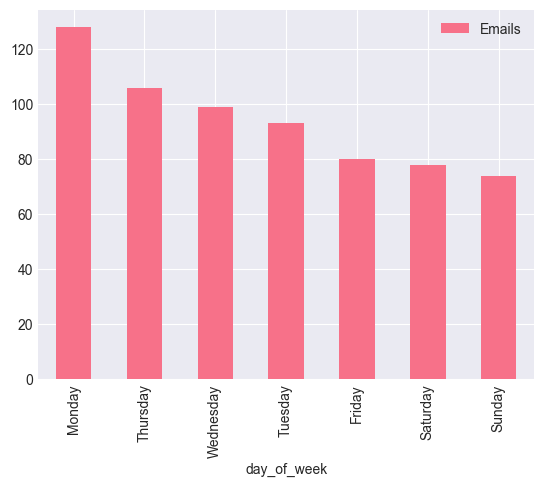

In [8]:
days_of_week_df.plot(kind = 'bar')

In [9]:
print(f"This month, {days_of_week_df.index[0]} is the busiest day of the week with {days_of_week_df.get('Emails').iloc[0]} emails received")

This month, Monday is the busiest day of the week with 128 emails received


### What time of the day do I get the most emails?

In [10]:
peak_time_df = df.groupby('time_of_day').count()
peak_time_df = peak_time_df.assign(Emails = peak_time_df.get('id')).get(['Emails']).sort_values(by = 'Emails', ascending=False)
peak_time_df

/var/folders/95/q1g02_4s37qclyv89d1mkgzr0000gn/T/ipykernel_25728/2083476114.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  peak_time_df = df.groupby('time_of_day').count()


,Emails
time_of_day,
Afternoon (12pm-6pm),269
Morning (6am-12pm),223
Evening (6pm-12am),98
Night (12am-6am),68


<Axes: xlabel='time_of_day'>

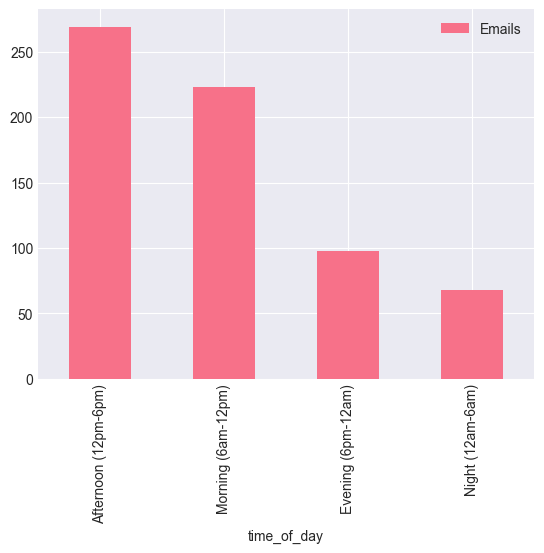

In [11]:
peak_time_df.plot(kind = 'bar')

In [12]:
peak_hour_df = df.groupby('hour').count()
peak_hour_df = peak_hour_df.assign(Emails = peak_hour_df.get('id')).get(['Emails']).sort_values(by = 'Emails', ascending=False)
peak_hour_df

,Emails
hour,
14,57
17,55
18,54
12,44
10,43
16,43
9,41
11,38
15,33


<Axes: xlabel='hour'>

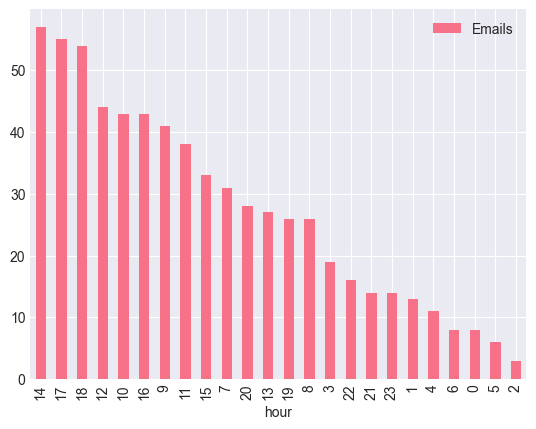

In [13]:
peak_hour_df.plot(kind = 'bar')

In [14]:
print(f"Peak time of day: {peak_time_df.index[0]}")
print(f"Peak hour of day: {peak_hour_df.index[0]}:00 (UTC)")

Peak time of day: Afternoon (12pm-6pm)
Peak hour of day: 14:00 (UTC)


### Do I get more emails on the weekdays or weekends

In [15]:
weekday_df = df[df.get('is_weekend') == False]
weekday_count = weekday_df.shape[0]

weekend_df = df[df.get('is_weekend') == True]
weekend_count = weekend_df.shape[0]

print(f"# of Weekday Emails: {weekday_count}")
print(f"# of Weekend Emails: {weekend_count}")

# of Weekday Emails: 506
# of Weekend Emails: 152


### Who emails me the most?

In [49]:
def extract_emails(text):
    # A common regex pattern for finding email addresses in text
    pattern = r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,3}"
    emails = re.findall(pattern, text)
    return emails[0]

df = df.assign(email_of_sender = df.get('sender').apply(extract_emails))

senders = df.groupby('email_of_sender').count()
senders = senders.assign(Count = senders.get('id'))
senders = senders.get(['Count']).sort_values(by = 'Count', ascending = False)
senders

,Count
email_of_sender,
notifications@instructure.com,79
alert@indeed.com,71
handshake@notifications.joinhandshake.com,56
noreply@ucsd.edu,34
tapiocaucsd@gmail.com,26
...,...
dscstudent@ucsd.edu,1
drive-shares-dm-noreply@google.com,1
notifications@link.com,1


In [68]:
relevent_senders = senders[senders.get('Count') >= 10]
relevent_senders

,Count
email_of_sender,
notifications@instructure.com,79
alert@indeed.com,71
handshake@notifications.joinhandshake.com,56
noreply@ucsd.edu,34
tapiocaucsd@gmail.com,26
no-reply@todoist.com,26
team@campuswiremail.com,26
nvn001@ucsd.edu,23
sina@uflo.io,16


### Are most my emails school or personal?

In [72]:
def is_school_email(email):
    return 'edu' in email

relevent_senders = relevent_senders.reset_index()
relevent_senders = relevent_senders.assign(school_email = relevent_senders.get('email_of_sender').apply(is_school_email))
relevent_senders

,index,email_of_sender,Count,school_email
0,0,notifications@instructure.com,79,False
1,1,alert@indeed.com,71,False
2,2,handshake@notifications.joinhandshake.com,56,False
3,3,noreply@ucsd.edu,34,True
4,4,tapiocaucsd@gmail.com,26,False
5,5,no-reply@todoist.com,26,False
6,6,team@campuswiremail.com,26,False
7,7,nvn001@ucsd.edu,23,True
8,8,sina@uflo.io,16,False
9,9,adminrec@ucsd.edu,11,True


<Axes: xlabel='school_email'>

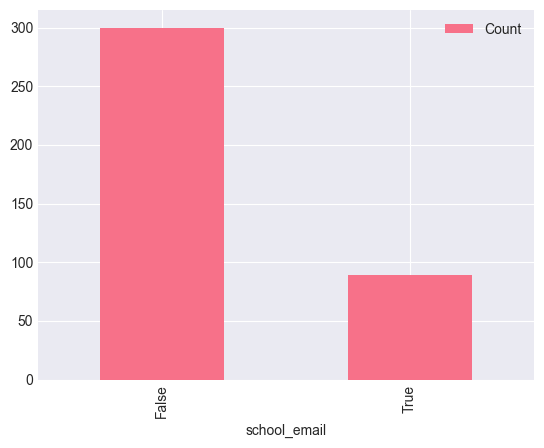

In [77]:
relevent_senders.groupby('school_email').sum().plot(kind = 'bar', y = 'Count')